In [1]:
import numpy as np
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.sampling import draw_sobol_samples

from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scalarize.acquisition.monte_carlo import qNoisyExpectedImprovement
from scalarize.utils.scalarization_objectives import get_utility_mcobjective
from scalarize.utils.scalarization_functions import HypervolumeScalarization
from scalarize.utils.scalarization_parameters import UnitVector
from scalarize.utils.transformations import estimate_bounds
from scalarize.models.transforms import Normalize

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def fit_model(train_X, train_Y):
    num_outputs = train_Y.shape[-1]
    model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=num_outputs))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


def test_fn(x):
    f1 = (
        torch.sin(torch.pi * x)
        - 2 * torch.sin(2 * torch.pi * x)
        + torch.sin(4 * torch.pi * x)
    )
    f2 = (
        torch.sin(torch.pi * x)
        + 2 * torch.sin(2 * torch.pi * x)
        + torch.sin(4 * torch.pi * x)
    )
    return torch.column_stack([f1, f2])

In [3]:
# initialize function
n = 201
x = torch.linspace(0, 1, n)
y = test_fn(x)

tkwargs = {"dtype": torch.double, "device": "cpu"}

bounds = torch.tensor([[0.0], [1.0]], **tkwargs)
train_X = torch.tensor(
    [
        [0.02],
        [0.25],
        [0.89],
    ],
    **tkwargs
)
train_Y = test_fn(train_X)

# initialize model
model = fit_model(train_X, train_Y)

posterior = model.posterior(x.unsqueeze(-1))
mean = posterior.mean.detach().numpy()
var = posterior.variance.detach().numpy()
std = np.sqrt(var)

beta = 4
up = mean + beta * std
lo = mean - beta * std

# get scalarization parameter
num_params = 500
num_outputs = 2
parameter_class = UnitVector(num_objectives=num_outputs, transform_label="polar")
nadir = torch.min(train_Y, dim=0).values - 0.1 * torch.min(abs(train_Y), dim=0).values
nadir = nadir.unsqueeze(0)

latent_param = torch.linspace(0, 0.99, num_params)
param = parameter_class.transform(latent_param.unsqueeze(-1))

# set MC sample for posterior
num_mc_samples = 2048
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_mc_samples]), seed=123)

In [4]:
# compute the EI for each scalarization parameter
acq_xs = []

for i in range(num_params):
    weights = param[i].unsqueeze(0)

    with torch.no_grad():
        pred_Y = model.posterior(train_X).mean

    scalarization_fn = HypervolumeScalarization(weights=weights, ref_points=nadir)
    estimated_bounds = estimate_bounds(Y_baseline=pred_Y)
    outcome_transform = Normalize(bounds=estimated_bounds)

    mc_obj = get_utility_mcobjective(
        scalarization_fn=scalarization_fn, outcome_transform=outcome_transform
    )

    acq = qNoisyExpectedImprovement(
        model=model,
        objective=mc_obj,
        X_baseline=train_X,
        sampler=sampler,
        prune_baseline=True,
        cache_root=True,
    )
    acq_x = acq(x.unsqueeze(-1).unsqueeze(-1))
    acq_xs = acq_xs + [acq_x]

C:\ProgramData\Anaconda3\envs\scalarize_repo\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [5]:
# compute the EI for the total utility
weights = param

with torch.no_grad():
    pred_Y = model.posterior(train_X).mean

scalarization_fn = HypervolumeScalarization(weights=weights, ref_points=nadir)
estimated_bounds = estimate_bounds(Y_baseline=pred_Y)
outcome_transform = Normalize(bounds=estimated_bounds)

mc_obj = get_utility_mcobjective(
    scalarization_fn=scalarization_fn, outcome_transform=outcome_transform
)

acq = qNoisyExpectedImprovement(
    model=model,
    objective=mc_obj,
    X_baseline=train_X,
    sampler=sampler,
    prune_baseline=True,
    cache_root=False,
)

acq_x = acq(x.unsqueeze(-1).unsqueeze(-1))

In [6]:
# compute the argmaxes
argmax_idx = []
argmax_x = []
total_max_idx = None
max_val = -torch.inf
for i in range(num_params):
    idx = torch.argmax(acq_xs[i])

    if torch.max(acq_xs[i]) > max_val:
        max_val = torch.max(acq_xs[i])
        total_max_idx = i

    argmax_idx = argmax_idx + [idx]
    argmax_x = argmax_x + [x[idx]]

argmax_x = torch.row_stack(argmax_x)

total_argmax_x = argmax_x[total_max_idx]
total_argmax_s = latent_param[total_max_idx]
avg_argmax_x = x[torch.argmax(acq_x)]
argmax_x = np.squeeze(argmax_x.detach().numpy())

In [7]:
# compute the plotting coordinates
X, theta = torch.meshgrid(x, latent_param, indexing="xy")

acq_vals = torch.zeros(theta.shape)
for i in range(num_params):
    acq_vals[i, :] = acq_xs[i]

x = x.detach().numpy()
tX = train_X.detach().numpy()
tY = train_Y.detach().numpy()

s_param = theta.detach().numpy()
x_param = X.detach().numpy()
acq_xs = acq_vals.detach().numpy()

avg_argmax_x = avg_argmax_x.detach().numpy()
total_argmax_x = total_argmax_x.detach().numpy()

zs = x[np.argmax(acq_xs, axis=1)]

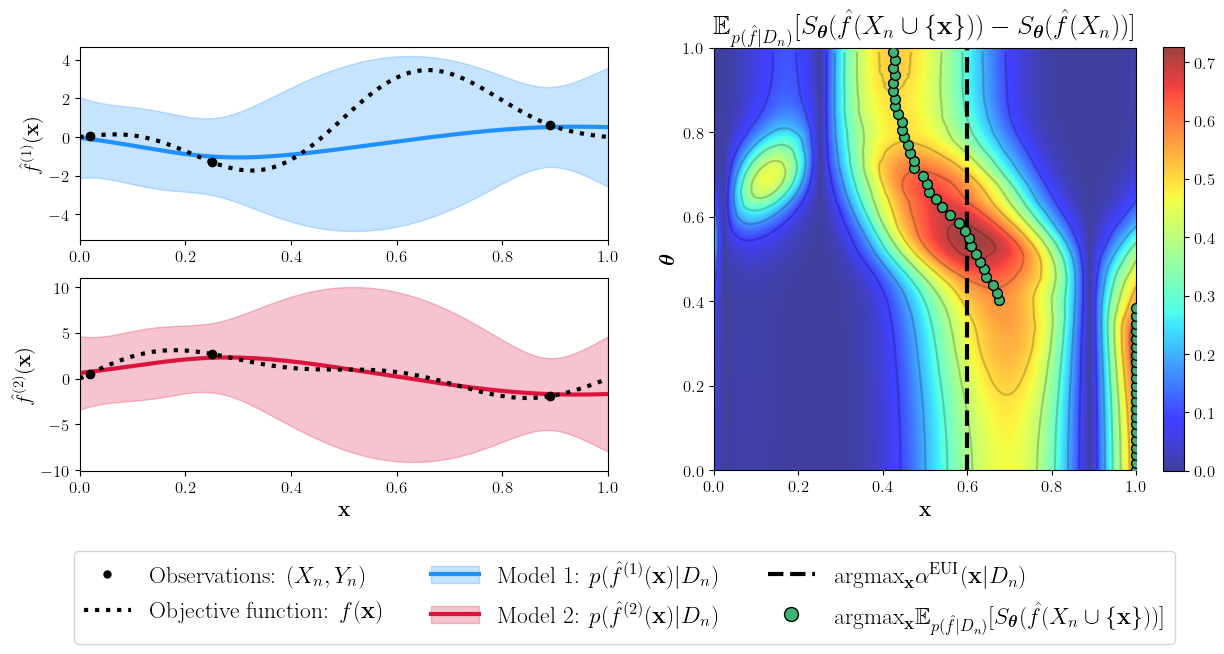

In [8]:
fig = plt.figure(figsize=(15, 5.5))
##################################################################################################
ax_1 = fig.add_subplot(2, 2, 1)
ax_1.scatter(tX, tY[:, 0], color="k", zorder=3)
ax_1.plot(x, mean[:, 0], color="dodgerblue", linewidth=3)
ax_1.fill_between(x, up[:, 0], lo[:, 0], color="dodgerblue", alpha=0.25)
ax_1.set_xlim(0, 1)
ax_1.set_ylabel(r"$\hat{f}^{(1)}(\mathbf{x})$", fontsize=15)
ax_1.plot(x, y[:, 0], color="k", linestyle=":", linewidth=3)
ax_1.set_title("", fontsize=19)
ax_1.tick_params(axis="both", labelsize=12)
##################################################################################################
ax_2 = fig.add_subplot(2, 2, 3)
ax_2.scatter(tX, tY[:, 1], color="k", zorder=3)
ax_2.plot(x, mean[:, 1], color="crimson", linewidth=3)
ax_2.fill_between(x, up[:, 1], lo[:, 1], color="crimson", alpha=0.25)
ax_2.set_xlim(0, 1)
ax_2.set_ylabel(r"$\hat{f}^{(2)}(\mathbf{x})$", fontsize=15)
ax_2.set_xlabel(r"$\mathbf{x}$", fontsize=15)
ax_2.plot(x, y[:, 1], color="k", linestyle=":", linewidth=3)
ax_2.tick_params(axis="both", labelsize=12)
##################################################################################################
ax_3 = fig.add_subplot(2, 2, (2, 4))
gain = r"$\mathbb{E}_{p(\hat{f}|D_n)}[S_{\boldsymbol{\theta}}(\hat{f}(X_n \cup \{\mathbf{x}\})) - S_{\boldsymbol{\theta}}(\hat{f}(X_n))]$"
# ws_ei = r"$p(\boldsymbol{\theta})$" + gain
ws_ei = gain
title = ws_ei

ax_3.contour(
    x_param, s_param, acq_xs, levels=np.linspace(0.1, 0.9, 9), colors="black", alpha=0.2
)
img = ax_3.imshow(acq_xs, extent=[0, 1, 0, 1], origin="lower", cmap="jet", alpha=0.75)
cbar = plt.colorbar(img, shrink=1)
cbar.ax.tick_params(labelsize=12)
ax_3.axvline(avg_argmax_x, color="k", alpha=1, linestyle="--", linewidth=3, zorder=4)

subset = list(np.floor(np.linspace(0, num_params - 1, 55)).astype(int))
ax_3.scatter(
    x[np.argmax(acq_xs, axis=1)][subset],
    latent_param[subset],
    zorder=5,
    color="mediumseagreen",
    marker="o",
    linestyle="None",
    s=50,
    edgecolor="k",
    linewidth=1,
)


ax_3.set_xlabel(r"$\mathbf{x}$", fontsize=15)
ax_3.set_ylabel(r"$\boldsymbol{\theta}$", fontsize=15)
ax_3.set_title(title, fontsize=19)
ax_3.tick_params(axis="both", labelsize=12)
##################################################################################################
black_dot = mlines.Line2D(
    [], [], color="k", marker=".", linestyle="None", markersize=10
)

blue_line = mlines.Line2D([], [], color="dodgerblue", linestyle="-", linewidth=3)
blue_patch = mpatches.Patch(color="dodgerblue", alpha=0.25)

red_line = mlines.Line2D([], [], color="crimson", linestyle="-", linewidth=3)
red_patch = mpatches.Patch(color="crimson", alpha=0.25)

red_dotted_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="--",
    linewidth=3,
)

black_dotted_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle=":",
    linewidth=3,
)
black_dashed_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="--",
    linewidth=3,
)

green_dot = mlines.Line2D(
    [],
    [],
    color="mediumseagreen",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=1,
)

labels = [
    r"Observations: $(X_n, Y_n)$",
    r"Objective function: $f(\mathbf{x})$",
    r"Model 1: $p(\hat{f}^{(1)}(\mathbf{x})| D_n)$",
    r"Model 2: $p(\hat{f}^{(2)}(\mathbf{x})| D_n)$",
    r"$\text{argmax}_{\mathbf{x}} \alpha^{\text{EUI}}(\mathbf{x}|D_n)$",
    r"$\text{argmax}_{\mathbf{x}} \mathbb{E}_{p(\hat{f}|D_n)}[S_{\boldsymbol{\theta}}(\hat{f}(X_n \cup \{\mathbf{x}\}))]$",
]

ax_2.legend(
    handles=[
        (black_dot),
        (black_dotted_line),
        (blue_line, blue_patch),
        (red_line, red_patch),
        (black_dashed_line),
        (green_dot),
    ],
    labels=labels,
    ncol=3,
    fontsize=17,
    loc=(-0.01, -0.9),
)

plt.show()

C:\Users\Ben\AppData\Local\Temp\ipykernel_20220\3110343005.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_rows, num_cols, (1, 4))


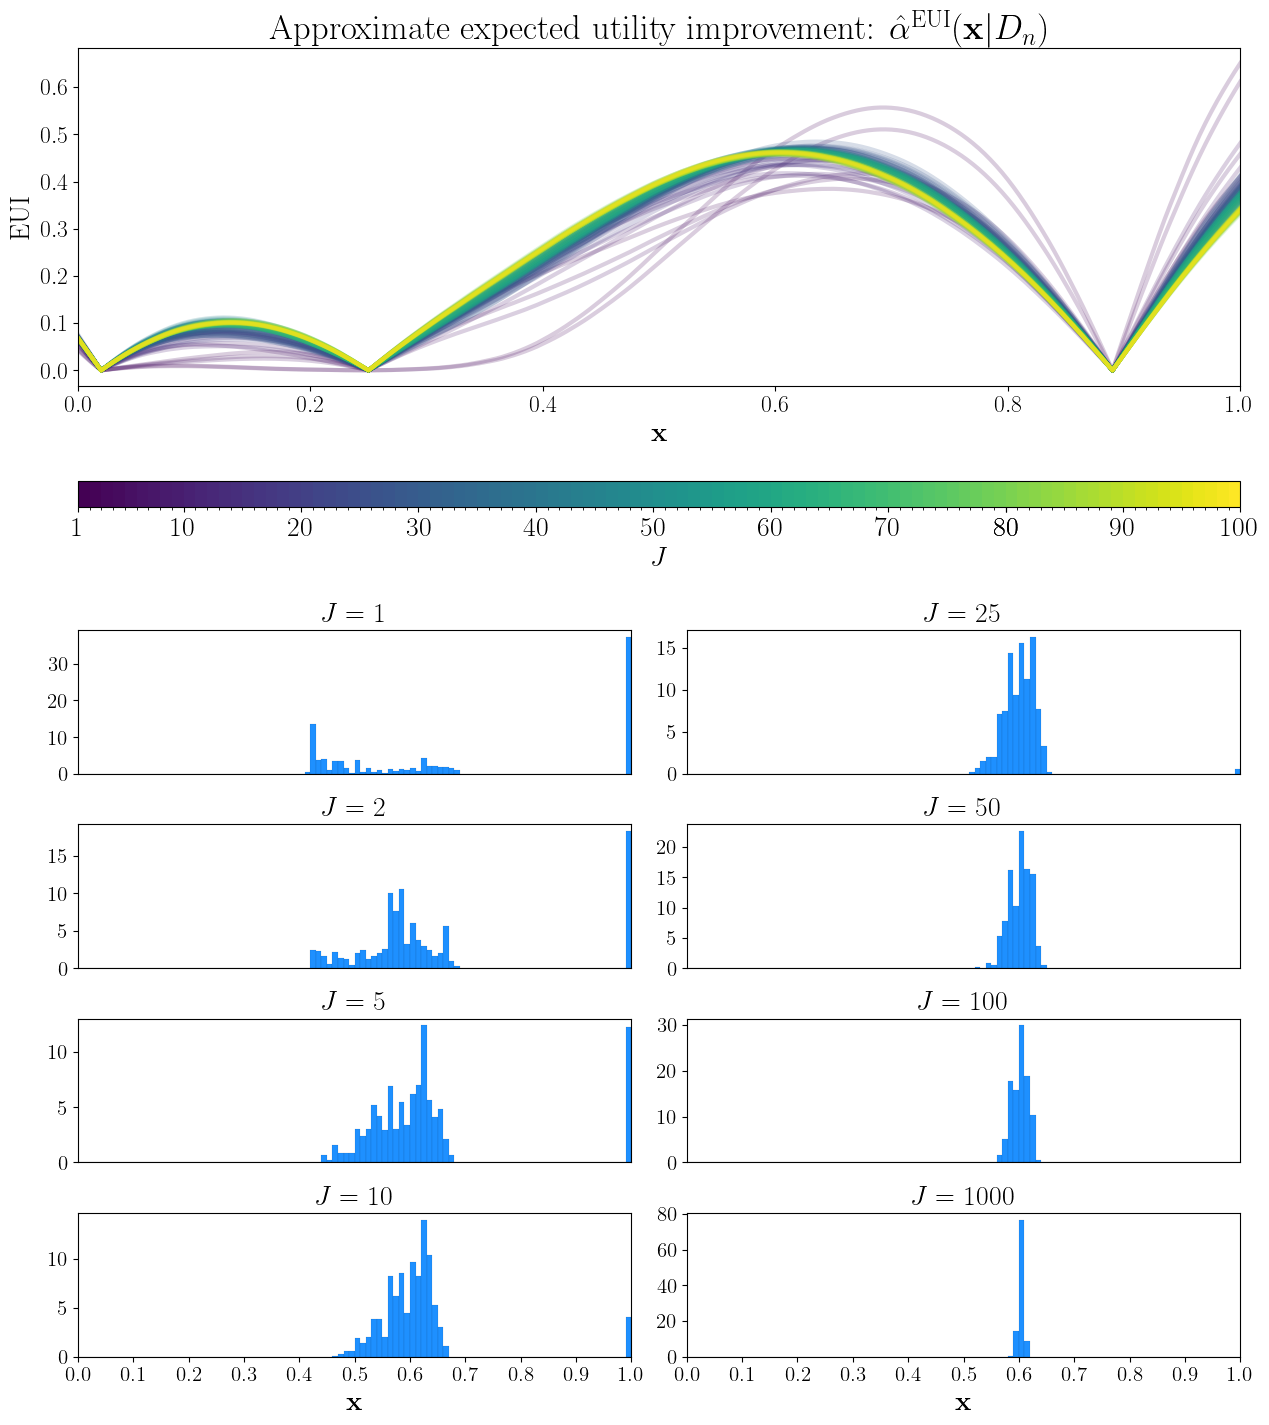

In [9]:
num_runs = 1000
num_cols = 2
num_rows = 7

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 17))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35
)

plt.subplot(num_rows, num_cols, (1, 4))
num_iterations = 100
colors = pl.cm.viridis(np.linspace(0, 1, num_iterations))
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_cmap", cmaplist, cmap.N
)
bounds = np.linspace(1, 100, 100)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
np.random.seed(2)
random_subset = np.random.choice(num_params, num_iterations)
for i in range(1, num_iterations):
    r_i = random_subset[0:i]
    plt.plot(
        x, np.mean(acq_xs[r_i, :], axis=0), color=colors[i], linewidth=3, alpha=0.2
    )
plt.xlim(0, 1)
plt.xlabel(r"$\mathbf{x}$", fontsize=20)
plt.ylabel(r"EUI", fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.title(
    r"Approximate expected utility improvement: $\hat{\alpha}^{\mathrm{EUI}}(\mathbf{x}| D_n)$",
    fontsize=25,
)
np.random.seed(123)
argmaxes = np.zeros(shape=(num_runs))

subset_sizes = [1, 25, 2, 50, 5, 100, 10, 1000]
for s in range(len(subset_sizes)):
    plt.subplot(num_rows, num_cols, s + 7)
    for r in range(num_runs):
        random_subset = np.random.choice(num_params, subset_sizes[s])
        a_val = np.mean(acq_xs[random_subset, :], axis=0)
        argmaxes[r] = x[np.argmax(a_val)]

    plt.hist(
        argmaxes,
        bins=np.linspace(0, 1, 101),
        color="dodgerblue",
        density=True,
        edgecolor="black",
        linewidth=0.05,
        label=r"$J={}$".format(subset_sizes[s]),
    )

    plt.yticks(fontsize=15)
    plt.xticks([])
    if s >= num_rows * num_cols - 8:
        plt.xlabel(r"$\mathbf{x}$", fontsize=20)
        plt.xticks(np.linspace(0, 1, 11), fontsize=15)

    plt.xlim(0, 1)
    plt.title(r"$J={}$".format(subset_sizes[s]), fontsize=20)

axes[2, 0].remove()
axes[2, 1].remove()

ax_bar = fig.add_axes([0.125, 0.61, 0.775, 0.015])

cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=norm,
    spacing="proportional",
    ticks=bounds + 0.5,
    boundaries=bounds,
    format="%1i",
    orientation="horizontal",
)
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100], fontsize=20)
plt.xlabel(r"$J$", fontsize=20)

plt.show()